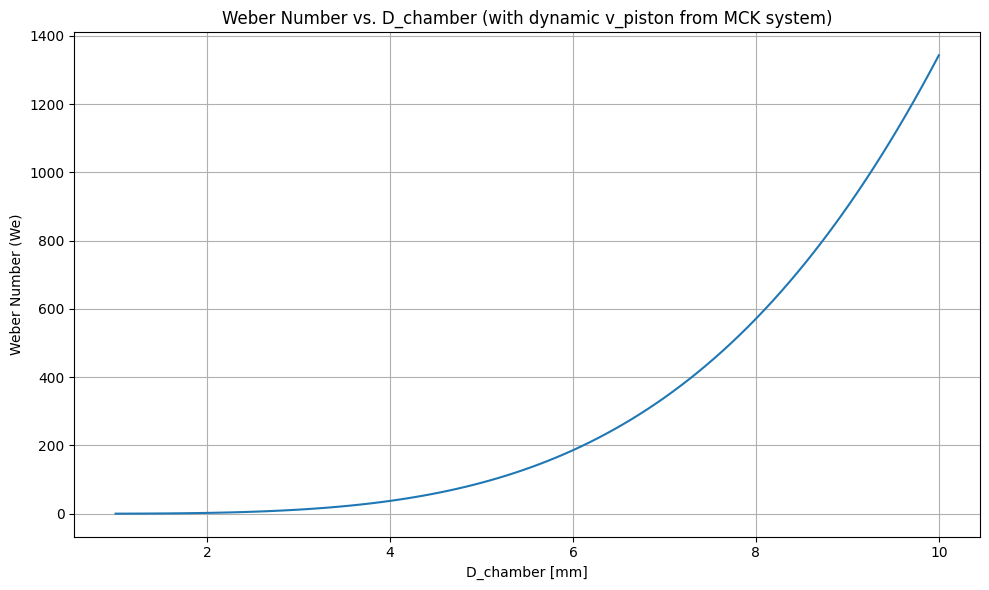

In [3]:
# 두 코드를 통합하여 MCK 시스템에서 얻은 v_piston을 Weber 수 모델에 반영

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ✅ 1. 상수 정의 (필요시 조정 가능)
k2 = 2800              # N/m
m = 0.05            # kg
rho = 1000          # kg/m^3
v_piston = 3        # m/s  ← 이 값은 실제 측정 필요
g = 9.81            # m/s^2
sigma = 0.0728      # N/m

# ⬇️ mm 단위 기반 정의
L_chamber = 0.5 * 1e-3       # m
x = 10.0 * 1e-3               # m (stroke length)
v = 2                     # m/s
D1 = 1.0 * 1e-3              # m
D2 = 0.2 * 1e-3              # m
L1 = 20.0 * 1e-3             # m
L2 = 5.0 * 1e-3             # m
K = 0.9                     # 충돌 수두손실
f_pipe = 0.03               # 유체 점성 수두손실
A_in = (np.pi/4)*D1**2                  # m^2

k1 = 1400                       # N/m
L_open = 1.0 * 1e-3          # m
f_gap = 0.3
E = 1e9                      # Pa
delta_gap = 0.001 * 1e-3       # m
h_packing = 1 * 1e-3      # m
t = 0.1                      # sec
t_final = 0.3

# 병렬 스프링 등가 강성
k = (k1 * k2) / (k1 + k2)

# ✅ 2. D_chamber 정의
D_chamber = np.linspace(0.001, 0.01, 100)
A_chamber = (np.pi / 4) * D_chamber**2

# ✅ 3. 평균 속도 계산 (MCK 시스템으로부터)
v_avg_array = []
for A_ch in A_chamber:
    c = (rho * 1.0 * A_ch) / 2  # 초기 속도는 1로 임의 가정

    def force(t):
        return 20.0

    def mck_system(t, y):
        x, v = y
        dxdt = v
        dvdt = (force(t) - c * v - k * x) / m
        return [dxdt, dvdt]

    def reach_stroke_limit(t, y):
        return y[0] - x_limit
    reach_stroke_limit.terminal = True
    reach_stroke_limit.direction = 1

    y0 = [0.0, 0.0]
    t_span = (0, t_final)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    sol = solve_ivp(
        mck_system,
        t_span,
        y0,
        t_eval=t_eval,
        events=reach_stroke_limit
    )

    v = sol.y[1]
    v_avg = np.mean(v)
    v_avg_array.append(v_avg)

v_avg_array = np.array(v_avg_array)

# ✅ 4. Weber 수 계산
# (1) 기하학 항
geom_term = np.sqrt((1 - f_pipe * L1 / D1) * (1 - K) * (1 - f_pipe * L2 / D2))
A_term = ((rho * D2 / sigma) * ((A_chamber / A_in) * geom_term))**2

# (2) 마찰력
F_friction = 2 * np.pi * f_gap * E * delta_gap * h_packing

# (3) F_mu.f
A_wall = np.pi * D_chamber * x_limit
F_muf = A_wall * (f_pipe * (L_chamber / D_chamber) * (1 / (2 * g)) * v_avg_array**2)

# (4) F_open
F_open = k1 * L_open

# (5) F_total 및 B_term
F_finger = 20.0
F_total = F_finger - F_friction - F_muf - F_open
B_term = np.clip(F_total, 0, None)**2

# (6) 감쇠 및 진동 응답 항
c_array = (rho * v_avg_array * A_chamber) / 2
zeta = c_array / (2 * np.sqrt(m * k2))
omega_n = np.sqrt(k2 / m)
omega_d = omega_n * np.sqrt(1 - zeta**2)

exp_term = np.exp(-zeta * omega_n * t)
dyn_term = (
    zeta * omega_n * (np.cos(omega_d * t) + (zeta * omega_n / omega_d) * np.sin(omega_d * t))
    - omega_d * (-np.sin(omega_d * t) + (zeta * omega_n / omega_d) * np.cos(omega_d * t))
)
C_term = ((exp_term / k2)**2) * (dyn_term**2)

# ✅ 최종 We 수
We = A_term * B_term * C_term

# ✅ 5. 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(D_chamber * 1000, We)
plt.xlabel('D_chamber [mm]')
plt.ylabel('Weber Number (We)')
plt.title('Weber Number vs. D_chamber (with dynamic v_piston from MCK system)')
plt.grid(True)
plt.tight_layout()
plt.show()
